### 1. Import and data loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,w_material_early,...,w_castled_early,b_castled_early,w_checks_early,b_checks_early,early_checks,w_piece_activity,b_piece_activity,both_castled_early,total_captures_early,activity_diff
0,2404,2534,0,0,130,2469.0,0,-130,0,20.0,...,0.0,1.0,0.0,0.0,0.0,34.0,33.0,0,11.0,1.0
1,2752,2395,2,0,357,2573.5,1,357,0,16.0,...,0.0,0.0,0.0,1.0,1.0,27.0,27.0,0,18.0,0.0
2,2558,2685,2,0,127,2621.5,0,-127,1,22.0,...,1.0,0.0,0.0,0.0,0.0,30.0,32.0,0,14.0,-2.0
3,2514,2351,0,0,163,2432.5,1,163,0,6.0,...,0.0,0.0,0.0,2.0,2.0,21.0,23.0,0,20.0,-2.0
4,2582,2494,2,0,88,2538.0,1,88,0,18.0,...,0.0,0.0,2.0,2.0,4.0,35.0,41.0,0,17.0,-6.0


### 2. Prepare data

In [3]:
X = df.drop('ResultNumeric', axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (1686173, 33)
Target: (1686173,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

#### Scale feature

In [5]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 4. Train model

In [6]:
lr_model = LogisticRegression(
    max_iter=2000,
    solver='saga',
    random_state=42,
    n_jobs=-1,
)

In [7]:
start_time = time.time()

lr_model.fit(X_train_scaled, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 19.66 seconds (0.33 minutes)


### 5. Evaluate

In [8]:
y_pred = lr_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report: \n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))

Accuracy: 0.6181 (61.81%)

Classification Report: 

              precision    recall  f1-score   support

   Black Win       0.61      0.68      0.64    132965
        Draw       0.67      0.29      0.40     64732
   White Win       0.62      0.71      0.66    139538

    accuracy                           0.62    337235
   macro avg       0.63      0.56      0.57    337235
weighted avg       0.62      0.62      0.60    337235



### 6. Confusion Matrix

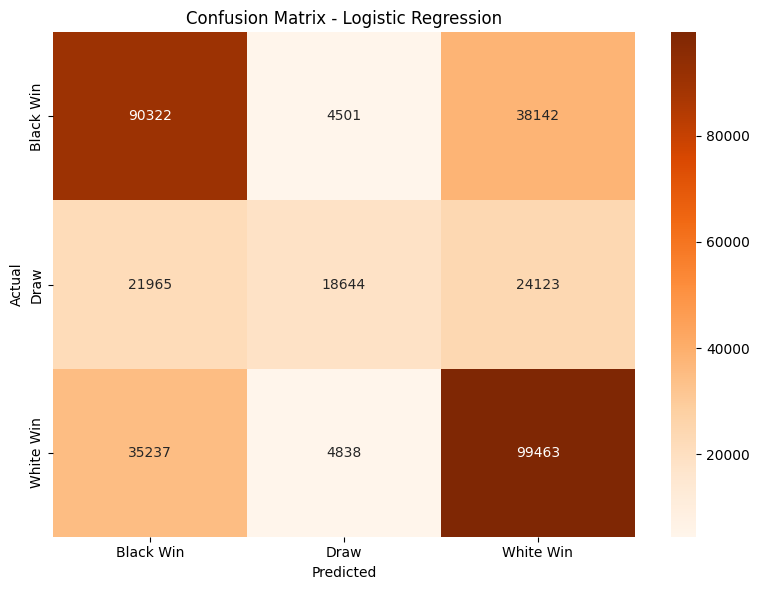

In [9]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Logistic Regression')
plt.tight_layout()
plt.show()

### 7. Coefficients (Feature importance for linear models)

                  Feature  Coefficient
10    material_diff_early     0.238624
6    WhiteRatingAdvantage     0.187714
0                WhiteElo     0.130081
1                BlackElo     0.129443
4               AvgRating     0.115161
2             EventTypeID     0.094125
8        w_material_early     0.075045
3              RatingDiff     0.071279
9        b_material_early     0.061205
13     capture_diff_early     0.056628
32          activity_diff     0.054613
29       b_piece_activity     0.038610
11       w_captures_early     0.034296
28       w_piece_activity     0.033654
5      WhiteIsHigherRated     0.027918
12       b_captures_early     0.026717
16  aggression_diff_early     0.025784
31   total_captures_early     0.024413
21          b_development     0.023135
22       development_diff     0.019079
15     b_aggression_early     0.018810
17       w_center_control     0.018770
7                   ECOID     0.018506
14     w_aggression_early     0.017731
18       b_center_control

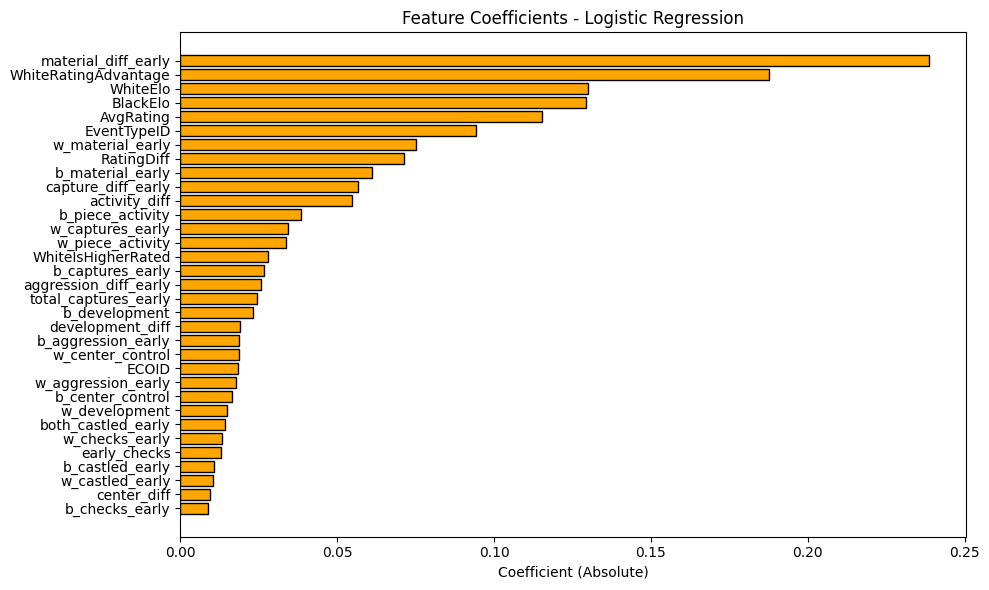

In [10]:
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': np.abs(lr_model.coef_).mean(axis=0)  # Average across classes
}).sort_values('Coefficient', ascending=False)

print(coef_df)

plt.figure(figsize=(10, 6))
plt.barh(coef_df['Feature'], coef_df['Coefficient'], 
         color='orange', edgecolor='black')
plt.xlabel('Coefficient (Absolute)')
plt.title('Feature Coefficients - Logistic Regression')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()